<a href="https://colab.research.google.com/github/Psyrus7/AtharvaShinde_INBT04755_September2023/blob/main/Major_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import io
import csv
import os
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [37]:
# Defining an empty list to store data lines
data_lines = []

In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [39]:
dataset_path =r'/content/drive/MyDrive/Project_test/IMDB Dataset.csv'
print(dataset_path)

/content/drive/MyDrive/Project_test/IMDB Dataset.csv


In [40]:
# Reading the dataset into memory and handling any potential parsing errors
with open(dataset_path, "r", encoding="utf-8") as file:
    for line in file:
        data_lines.append(line)

# Concatenate the data lines to create the CSV content
csv_content = ''.join(data_lines)

try:
    imdb = pd.read_csv(io.StringIO(csv_content)) # Reads the CSV content into a DataFrame
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
    print("Dataset Structure:")
print(imdb.info()) #dispalys the structure of database

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [41]:
# Download necessary NLP resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
# Data Cleaning Tasks :

# Handling missing values (if any)
imdb.dropna(inplace=True)

# Removing duplicates
imdb.drop_duplicates(inplace=True)

# Verifing sentiment labels and address any inconsistencies
# ensuring sentiment labels are 'positive' and 'negative'
sentiment_distribution = imdb['sentiment'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution)

# Save the cleaned dataset to a CSV file (optional)
imdb.to_csv('/content/drive/MyDrive/Project_test/cleaned_imdb.csv', index=False)


Sentiment Distribution:
positive    24884
negative    24698
Name: sentiment, dtype: int64


In [43]:
def preprocess_text(text):
    # Removing HTML tags and other special characters
    text = re.sub(r'<[^>]+>br[^a-zA-Z\s]<br /><br />', '', text)

    # Converting text to lowercase
    text = text.lower()

    # Tokenizing the text
    words = word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    # Stem the words
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # Join the words back into a single string
    preprocessed_text = ' '.join(stemmed_words)

    return preprocessed_text
# Creating the 'preprocessed_review' column in the DataFrame
imdb['preprocessed_review'] = ""
# Applying preprocessing to the 'review' column in batches for reducing memory load
batch_size = 10000
num_batches = len(imdb) // batch_size + 1

for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size
    imdb['preprocessed_review'].iloc[batch_start:batch_end] = imdb['review'].iloc[batch_start:batch_end].apply(preprocess_text)
    # Concatenate the columns into a single 'preprocessed_review' column
imdb['preprocessed_review'] = imdb.iloc[:, 0:].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Save the preprocessed dataset to a CSV file (optional)
imdb.to_csv("/content/drive/MyDrive/Project_test/preprocessed_imdb.csv", index=False)

In [44]:
# Loading the preprocessed dataset
dataset_path = '/content/drive/MyDrive/Project_test/preprocessed_imdb.csv'
imdb = pd.read_csv(dataset_path)

# Spliting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imdb['preprocessed_review'], imdb['sentiment'], test_size=0.2, random_state=42)

# Feature Extraction using TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# Initialize and train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier using TF-IDF features
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set using TF-IDF features
y_pred_tfidf = nb_classifier.predict(X_test_tfidf)

# Calculate accuracy and display classification report for TF-IDF
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
report_tfidf = classification_report(y_test, y_pred_tfidf)

# Print results
print("\nResults for TF-IDF Features:")
print(f"Accuracy: {accuracy_tfidf}")
print(f"Classification Report:\n{report_tfidf}")


Results for TF-IDF Features:
Accuracy: 0.8805082182111525
Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.89      0.88      4939
    positive       0.89      0.87      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



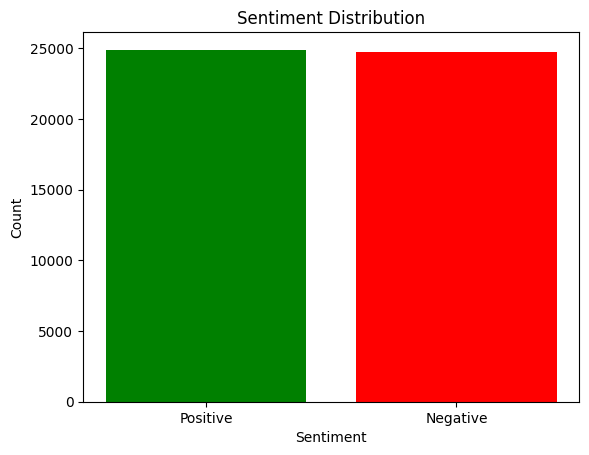

In [45]:
# Visualizing sentiment distribution
sentiment_counts = imdb['sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.xticks(sentiment_counts.index, ['Positive', 'Negative'])
plt.show()

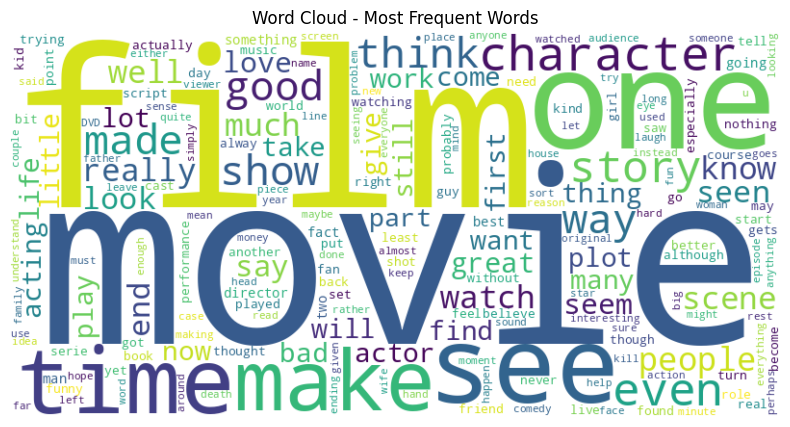

In [51]:
# Creating word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(imdb['preprocessed_review']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Most Frequent Words')
plt.show()

     Word  Frequency
0   movie      84374
1    film      76389
2     one      50840
3    good      28482
4    even      24314
5    time      23303
6  really      22809
7     see      22342
8   story      22159
9  people      17743


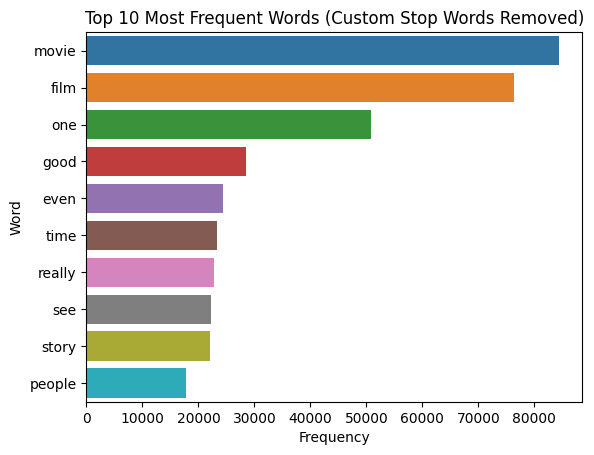

In [47]:
# Visualizing top N most frequent words

# Defining our custom list of stop words because for plotting the bar graph we do not want unneccesary words which has no meanings:
custom_stop_words = set(["the", "and", "is", ",", ".", "-", ">", "of", "is", "/", "to","this","that","was","with","for","but","you","n't","not","are","his","have",
                         "they","all","who","from","like","there","just","her","has","out","what","some","more","very","when","she","would","about","can","which",
                         "only","were","their","had","did","does","...","than","much","well","could","get","been","will","other"])

# Function to preprocess and clean the text
def preprocess_text(text):
    # Remove HTML tags like "<br>"
    text = re.sub(r'<.*?>', '', text)
    return text

# Preprocess the text to remove "<br>" and any other HTML tags
imdb['preprocessed_review'] = imdb['review'].apply(preprocess_text)

# Tokenize the preprocessed text and remove stop words
word_tokens = [word_tokenize(text.lower()) for text in imdb['preprocessed_review']]
filtered_words = [[word for word in tokens if word not in custom_stop_words and len(word) > 2] for tokens in word_tokens]

# Flatten the list of words
all_words = [word for sublist in filtered_words for word in sublist]

# Count word frequencies
word_counts = Counter(all_words)

# Get the top N most frequent words
top_n = 10  # Change this to the desired number of top words
top_words = word_counts.most_common(top_n)

# Create a DataFrame for the top words
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
print(top_words_df)

# Create a bar graph for the top N most frequent words
sns.barplot(x='Frequency', y='Word', data=top_words_df)
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title(f'Top {top_n} Most Frequent Words (Custom Stop Words Removed)')
plt.show()

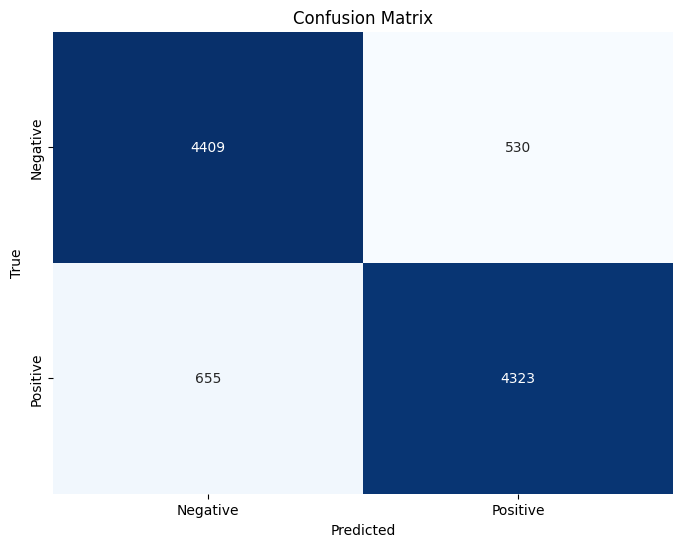

In [48]:
# Ploting confusion matrix
confusion = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

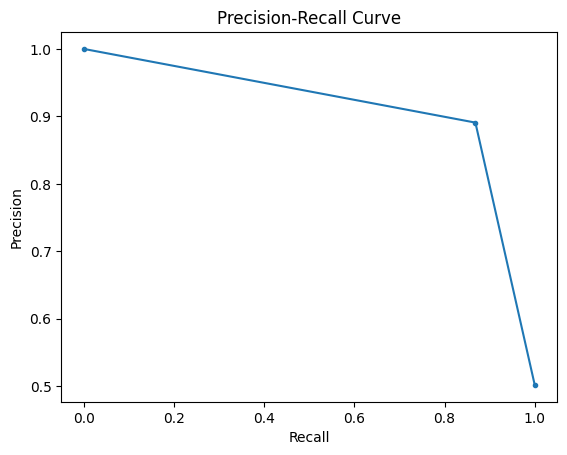

In [49]:
# Ploting precision-recall curve
y_test_binary = y_test.map({'negative': 0, 'positive': 1})
y_pred_bow_binary = pd.Series(y_pred_tfidf).map({'negative': 0, 'positive': 1}).to_numpy()
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_bow_binary)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

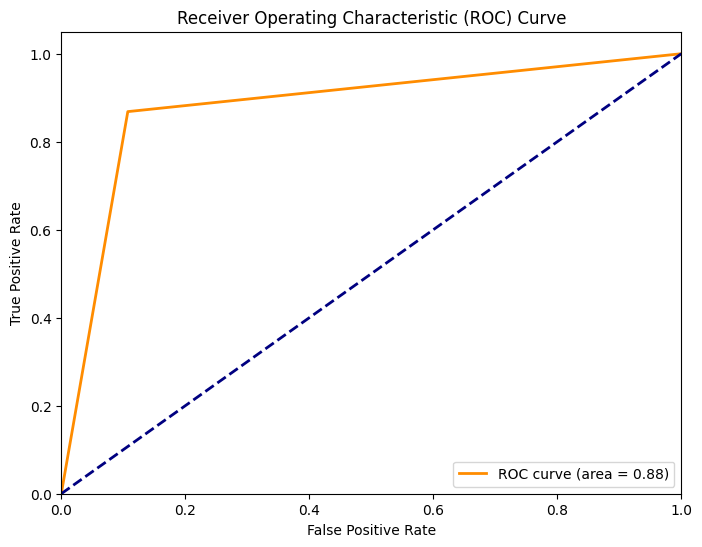

In [50]:
# Ploting ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_bow_binary)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()